I’ll collect data from a YouTube video for this task, for which we need to use the YouTube data API. You can follow the steps below to sign up and get access to the YouTube data API:

1. Go to Google Cloud Console.
2. Click on the project drop-down at the top, then “New Project”.
3. Enter a project name and click “Create”.
4. In the Google Cloud Console, navigate to “APIs & Services” > “Library”.
5. Search for “YouTube Data API v3” and click on it.
6. Click “Enable”.
7. Go to “APIs & Services” > “Credentials”.
8. Click “+ CREATE CREDENTIALS” and select “API key”.
9. Copy the generated API key.













In [3]:
!pip install youtube-transcript-api


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.3/622.3 kB 24.2 MB/s eta 0:00:00


In [5]:
import re
import csv
import pandas as pd
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi

API_KEY = 'Your API Key'

def get_video_id(url):
    # extract video id from the URL
    video_id_match = re.search(r'(?:v=|\/)([0-9A-Za-z_-]{11}).*', url)
    return video_id_match.group(1) if video_id_match else None

def get_video_title(video_id):
    # build the youTube service
    youtube = build('youtube', 'v3', developerKey=API_KEY)

    # fetch the video details
    request = youtube.videos().list(
        part='snippet',
        id=video_id
    )
    response = request.execute()

    # extract the title
    title = response['items'][0]['snippet']['title'] if response['items'] else 'Unknown Title'
    return title

def get_video_transcript(video_id):
    # fetch the transcript
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        return transcript
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

def save_to_csv(title, transcript, filename):
    # save the title and transcript to a CSV file
    transcript_data = [{'start': entry['start'], 'text': entry['text']} for entry in transcript]
    df = pd.DataFrame(transcript_data)
    df.to_csv(filename, index=False)

    # save the title separately
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Title:', title])

def main():
    url = input('Enter the YouTube video link: ')
    video_id = get_video_id(url)

    if not video_id:
        print('Invalid YouTube URL.')
        return

    title = get_video_title(video_id)
    transcript = get_video_transcript(video_id)

    if not transcript:
        print('No transcript available for this video.')
        return

    filename = f"{video_id}_transcript.csv"
    save_to_csv(title, transcript, filename)
    print(f'Transcript saved to {filename}')

if __name__ == '__main__':
    main()

Enter the YouTube video link: https://youtu.be/HKtryoXkNs4?si=eLoxM9jlnjO7wJxv
Transcript saved to HKtryoXkNs4_transcript.csv


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# load the dataset
transcript_df = pd.read_csv("HKtryoXkNs4_transcript.csv")
print(transcript_df.head())

    start                                   text
0    0.89                                [Music]
1  19.279              it can't be said I'm unly
2  22.359            bir it's 10: before I say a
3   26.76  word baby I can never tell how do you
4  30.599   sleep so well you keep telling me to


In [8]:
transcript_df['start'] = pd.to_numeric(transcript_df['start'], errors='coerce')

print("Dataset Overview:")
print(transcript_df.info())
print("\nBasic Statistics:")
print(transcript_df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   start   62 non-null     float64
 1   text    63 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.1+ KB
None

Basic Statistics:
            start
count   62.000000
mean   126.361613
std     67.792603
min      0.890000
25%     64.979000
50%    129.939500
75%    185.949000
max    240.439000


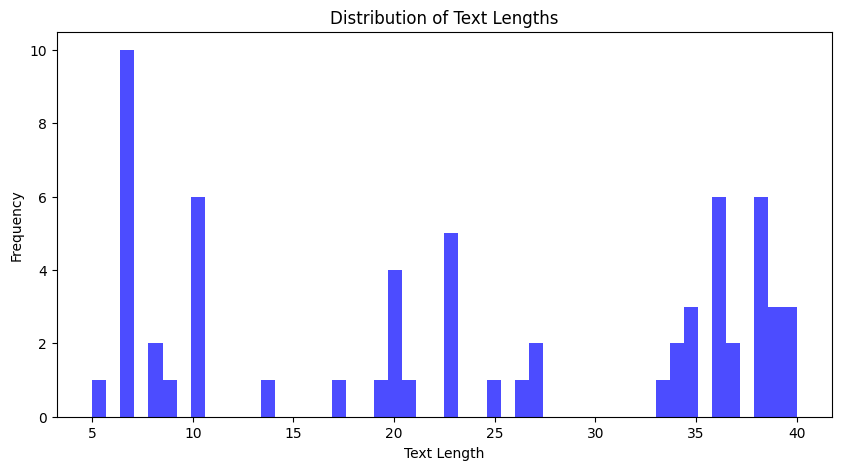

In [9]:
# distribution of text lengths
transcript_df['text_length'] = transcript_df['text'].apply(len)
plt.figure(figsize=(10, 5))
plt.hist(transcript_df['text_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

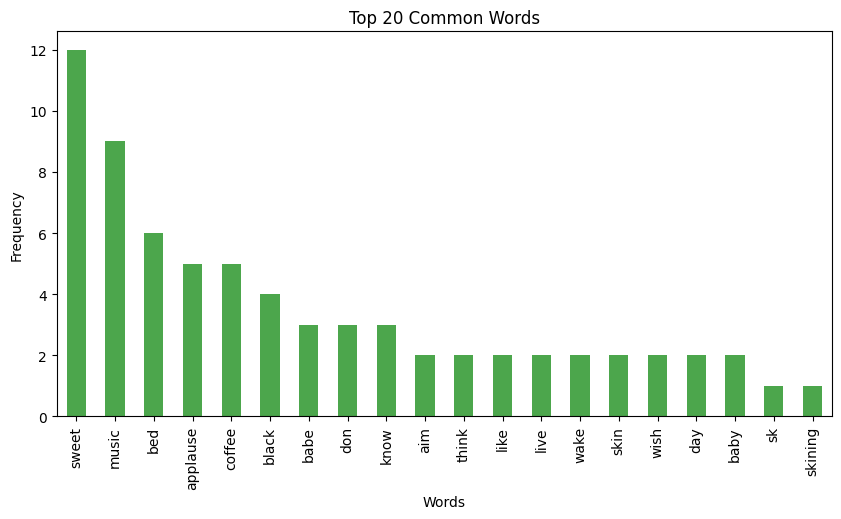

In [10]:
# most common words
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(transcript_df['text'])
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
common_words = word_counts_df.sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 5))
common_words.plot(kind='bar', color='green', alpha=0.7)
plt.title('Top 20 Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [11]:
# topic Modeling using NMF
n_features = 1000
n_topics = 10
n_top_words = 10

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(transcript_df['text'])
nmf = NMF(n_components=n_topics, random_state=42).fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(" ".join(topic_words))
    return topics

topics = display_topics(nmf, tf_feature_names, n_top_words)
print("\nIdentified Topics:")
for i, topic in enumerate(topics):
    print(f"Topic {i + 1}: {topic}")


Identified Topics:
Topic 1: coffee bed black skin wish don babe baby day know
Topic 2: sweet wish don babe baby bed black coffee day know
Topic 3: music baby skin black wish day babe bed coffee know
Topic 4: don baby wish know babe skin music live like wake
Topic 5: applause don babe baby bed black coffee day wish wake
Topic 6: know live don babe baby bed black coffee day wish
Topic 7: babe think wish don baby bed black coffee day know
Topic 8: day bed baby wish don babe black coffee know wake
Topic 9: wake baby wish don babe bed black coffee day know
Topic 10: like wish don babe baby bed black coffee day know


In [12]:
# get topic distribution for each text segment
topic_distribution = nmf.transform(tf)

# align the lengths by trimming the extra row in topic_distribution
topic_distribution_trimmed = topic_distribution[:len(transcript_df)]

# compute the dominant topic for each text segment
transcript_df['dominant_topic'] = topic_distribution_trimmed.argmax(axis=1)

In [13]:
# analyze the content of each text segment to manually identify logical breaks
logical_breaks = []

for i in range(1, len(transcript_df)):
    if transcript_df['dominant_topic'].iloc[i] != transcript_df['dominant_topic'].iloc[i - 1]:
        logical_breaks.append(transcript_df['start'].iloc[i])

In [14]:
# consolidate the logical breaks into broader chapters
threshold = 60  # seconds
consolidated_breaks = []
last_break = None

for break_point in logical_breaks:
    if last_break is None or break_point - last_break >= threshold:
        consolidated_breaks.append(break_point)
        last_break = break_point

In [15]:
# merge consecutive breaks with the same dominant topic
final_chapters = []
last_chapter = (consolidated_breaks[0], transcript_df['dominant_topic'][0])

for break_point in consolidated_breaks[1:]:
    current_topic = transcript_df[transcript_df['start'] == break_point]['dominant_topic'].values[0]
    if current_topic == last_chapter[1]:
        last_chapter = (last_chapter[0], current_topic)
    else:
        final_chapters.append(last_chapter)
        last_chapter = (break_point, current_topic)

final_chapters.append(last_chapter)  # append the last chapter

In [16]:
# Convert the final chapters to a readable time format
chapter_points = []
chapter_names = []

for i, (break_point, topic_idx) in enumerate(final_chapters):
    chapter_time = pd.to_datetime(break_point, unit='s').strftime('%H:%M:%S')
    chapter_points.append(chapter_time)

    # get the context for the chapter name
    chapter_text = transcript_df[(transcript_df['start'] >= break_point) & (transcript_df['dominant_topic'] == topic_idx)]['text'].str.cat(sep=' ')

    # extract key phrases to create a chapter name
    vectorizer = TfidfVectorizer(stop_words='english', max_features=3)
    tfidf_matrix = vectorizer.fit_transform([chapter_text])
    feature_names = vectorizer.get_feature_names_out()
    chapter_name = " ".join(feature_names)

    chapter_names.append(f"Chapter {i+1}: {chapter_name}")

# display the final chapter points with names
print("\nFinal Chapter Points with Names:")
for time, name in zip(chapter_points, chapter_names):
    print(f"{time} - {name}")


Final Chapter Points with Names:
00:00:19 - Chapter 1: music
00:01:28 - Chapter 2: grape sit sweet
00:03:34 - Chapter 3: applause
